# 0. Set-up

In [5]:
import os
import re
import sys
import pickle
import importlib
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
from collections import Counter

import osmnx as ox 
import networkx as nx
from shapely.geometry import Point, Polygon, LineString

import time
import igraph as iG
from igraph import Graph

import plotly as py
import plotly.graph_objs as go

def reload_module(module):
    importlib.reload(module)

# Specify the directory containing the .py modules
module_dir = "../modules"

# Add the directory to the Python path
sys.path.append(os.path.abspath(module_dir))

def value_formatter(x, pos=None):
    # Format with commas as thousand separators
    return f"{abs(int(x)):,}" if x == int(x) else f"{abs(x):,.2f}"

# 1. Load Knowledge Base & Map Resources

In [2]:
import datasets

reload_module(datasets)
from datasets import KnowledgeBase

import map_resources

reload_module(map_resources)
from map_resources import MapResources

In [3]:
# A wide dataframe for PUBLIC schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_public_datasets.csv'
public = pd.read_csv(fpath, index_col='school_id')
# print(public.shape)

# A wide dataframe for PRIVATE schools that also contain variables that can be used as node attributes
fpath = '../datasets/processed/compiled_private_datasets.csv'
private = pd.read_csv(fpath, index_col='school_id')
# print(private.shape)

# Initialize class that also preloads and reorganizes PSGC shapefiles
mr = MapResources(preloaded=True)

# The gpd_gadm is the dataframe of the shapefiles of Philippines following PSGC with EPSG:4326
gpd_gadm = mr.gadm.copy()

# The output is a dictionary of complete filepaths where the keys are the PSGC region names
# of our 17 regions. These are OSMNX drive graph networks
mr.get_filepaths_of_regional_road_networks()

# Additional preprocessing is done on our compiled public & private datasets
gdf_public = mr.preprocess_public_school_coordinates_further(public)
gdf_private = mr.preprocess_private_school_coordinates_further(private)

# 2. Build School Networks
* * *
We will use our `optimized_network_builder` module to facilitate the preparation and generation of the graph network of our schools using our compiled knowledge base and organized shapefiles. We provide a high-level overview below of how the project generates a graph network of schools.

<dl>
    Given the PSGC code of a target region:
    <ol type="1">
      <li>We get the shapefiles/geographies of the target region and its adjacent localities</li>
      <li>Using the above shapefiles, we extract the public and private schools in the target region and extract private schools that fall within the target and adjacent areas</li>
      <li>Still using the shapefiles, we cutout the drive network from our preloaded & locally saved OSMNX graph networks</li>
      <li>Feed the following to our network builder:
        <ol type="1">
          <li>Target & adjacent shapefiles</li>
          <li>Public and private schools</li>
          <li>Drive graph network</li>
        </ol>
      </li>
      <li>Run network builder algorithm</li>
    </ol>
</dl>

For this notebook, we demonstrate the generation of a network of schools in Region IV-A.

In [4]:
import optimized_network_builder

reload_module(optimized_network_builder)
from optimized_network_builder import OptimizedSchoolNetworkBuilder

## 2.1. Region IV-A

### 2.1.1. Extract geographies

We extract the shapes of our target geography and its adjacent geographies. `max_depth` here determines how far the algorithm will crawl outward from the target region when extracting adjacent geographies.

In [6]:
target_psgc = '0400000000' # Region IV-A
max_depth = 3
geo_results = mr.get_adjacent_geographies(
    gpd_gadm=gpd_gadm, 
    target_psgc=target_psgc, 
    max_depth=max_depth
)

Finding adjacent geographies for PSGC 0400000000 with max_depth=3
Detected administrative level: region
Finding adjacent areas at depth 1...
Found 62 adjacent areas at depth 1
Finding adjacent areas at depth 2...
Found 101 adjacent areas at depth 2
Finding adjacent areas at depth 3...
Found 136 adjacent areas at depth 3
Geography processing completed in 8.96 seconds


In [7]:
# We display the content of geo_results for reference
geo_results.keys()

dict_keys(['target_area', 'adjacent_areas', 'search_area_complete', 'target_shape', 'adjacent_shapes', 'search_shape_complete'])

<dl>
To provide a brief description of the contents of <strong>geo_results</strong>:
    <ol>
        <li>target_area: A GeoDataFrame containing the polygons of the target geography</li>
        <li>adjacent_areas: A dictionary whose keys are 1,2,3 (for max_depth of 3) whose values are GeoDataFrames containing the polygons of the adjacent geographies to the target</li>
        <li>search_area_complete: A GeoDataFrame containing the polygons of the target and adjacent geographies</li>
        <li>target_shape, adjacent_shapes, & search_shape_complete: A .unary_union of the above GeoDataFrames</li>
    </ol>
</dl>

### 2.1.2. Extract public & private schools

In [8]:
%%time
# Extracting schools using extracted geographies
school_results = mr.extract_schools_from_geographies(
    geography_results=geo_results,
    gdf_public=gdf_public,
    gdf_private=gdf_private
)

Extracting schools from geographies...
Prepared geometries in 0.00 seconds
Extracting public schools...
Public target query completed in 0.07 seconds
Found 3548 public schools in target area
Public adjacent depth 1 query completed in 0.02 seconds
Found 118 public schools in adjacent areas at depth 1
Public adjacent depth 2 query completed in 0.02 seconds
Found 174 public schools in adjacent areas at depth 2
Public adjacent depth 3 query completed in 0.02 seconds
Found 203 public schools in adjacent areas at depth 3
Extracting private schools...
Private search area query completed in 340.51 seconds
Found 2653 private schools in the entire search area
Private target query completed in 0.02 seconds
Found 1950 private schools in target area
Private adjacent depth 1 query completed in 0.01 seconds
Found 193 private schools in adjacent areas at depth 1
Private adjacent depth 2 query completed in 0.02 seconds
Found 296 private schools in adjacent areas at depth 2
Private adjacent depth 3 quer

In [9]:
# We display the content of geo_results for reference
school_results.keys()

dict_keys(['public_schools_in_target', 'public_schools_in_adjacent', 'private_schools_in_target', 'private_schools_in_adjacent', 'private_schools_all'])

We categorize schools (public and private) within the target geography as `origin` and schools adjacent to the target as `destination`. This is to facilitate our pathing algorithm later from one origin school to many destination schools.

We then plot our search area along with our extracted public and private schools to inspect if we, more or less, captured what we need in our target region.

In [10]:
# %%time
# fig, ax = plt.subplots(figsize=(8,8))

# geo_results['target_area'].plot(
#     ax=ax, facecolor='lightgrey', edgecolor='gray',
#     linewidth=.25
# )
# for k, v in geo_results['adjacent_areas'].items():
#     df_adj = geo_results['adjacent_areas'].get(k)
#     df_adj.plot(
#         ax=ax, facecolor='none', edgecolor='black',
#         linewidth=.25
#     )

# school_results['public_schools_in_target'].plot(
#     ax=ax, facecolor='forestgreen',
#     edgecolor='black', linewidth=.25,
#     marker='.', markersize=30
# )
# school_results['private_schools_all'].plot(
#     ax=ax, facecolor='navy',
#     edgecolor='black', linewidth=.25,
#     marker='*', markersize=5
# )

# ax.axis('off')

# plt.show()

### 2.1.3. Extract drive graph network

In [11]:
# We cull a subgraph from locally saved regional drive graph networks
G_sub = mr.generate_subgraph(geo_results)

Generating subgraph from geo_results
Subgraph extracted. Time elapsed: 2.56 minutes


In [12]:
# %%time
# # For sanity, we plot our geographies and subgraph road network
# fig, ax = ox.plot_graph(
#     G_sub, figsize=(10,10),
#     node_size=.5, edge_linewidth=.5,
#     bgcolor='none', show=False, close=False,
#     node_zorder=4, edge_color='black',
# )

# geo_results['target_area'].dissolve(by='adm2_psgc').plot(
#     ax=ax, facecolor='none', edgecolor='navy',
#     linewidth=1, alpha=1, zorder=3
# )

# df_adjs = []
# for k, v in geo_results['adjacent_areas'].items():
#     df_adj = geo_results['adjacent_areas'].get(k)
#     df_adj.plot(
#         ax=ax, facecolor='none', edgecolor='lightgrey',
#         linewidth=.25, zorder=2
#     )
#     df_adjs.append(df_adj)
# df_adjs = pd.concat(df_adjs)

# plt.show()

### 2.1.4. Build network

Overall, we make three groups of schools, namely: 1) public schools within target geography, 2) private schools within target geography, and 3) public and private schools in adjacent geographies.

In [13]:
# We explicitly identify the major groups that will comprise the school network
# This will be removed in the future since we will connect schools with each other regardless of groups
public_in_city = school_results['public_schools_in_target'].copy()
print(public_in_city.shape)

# My private dataframe has columns with "validated" coordinates - we explicitly call them here
private_in_space = school_results['private_schools_in_target'].copy()
private_in_space = private_in_space.drop(columns=['longitude','latitude'])
private_in_space = private_in_space.rename(
    columns={'longitude_valid':'longitude', 'latitude_valid':'latitude'}
)
print(private_in_space.shape)

# Public schools adjacent
adjacent_dfs = [v for k,v in school_results['public_schools_in_adjacent'].items()]
public_periph = pd.concat(adjacent_dfs)
# print(public_periph.shape)

# Private schools adjacent
adjacent_dfs = [v for k,v in school_results['private_schools_in_adjacent'].items()]
private_periph = pd.concat(adjacent_dfs)
private_periph = private_periph.drop(columns=['longitude','latitude'])
private_periph = private_periph.rename(
    columns={'longitude_valid':'longitude', 'latitude_valid':'latitude'}
)
# print(private_periph.shape)

# A dataframe of adjacent PUBLIC and PRIVATE schools
all_periph = pd.concat([public_periph, private_periph])
print(all_periph.shape)

(3548, 25)
(1950, 41)
(1198, 42)


In [14]:
# Initialize the optimized builder
network_builder = OptimizedSchoolNetworkBuilder(
    road_network_graph=G_sub,
    public_schools_gdf=public_in_city.reset_index(),
    private_schools_gdf=private_in_space.reset_index(),
    peripheral_schools_gdf=all_periph.reset_index(),
    admin_boundary=geo_results['target_area'],
    num_processes=None  # None means parallelization will use all available CPUs
)

In [16]:
%%time
# Build the complete network in one call
results = network_builder.build_complete_network(
    buffer_distance_m=5000,
    max_distance_km=15
)

🚀 Starting optimized network build...
📊 Setting up master infrastructure...
School counts: Public=3548, Private=1950, Peripheral=1198
Combined 6696 total schools
🔄 Converting NetworkX to iGraph...
Projected graph: 380100 nodes, 985152 edges
Created iGraph with 380100 vertices and 985152 edges
🔄 Creating WGS84 version of master iGraph...
Created iGraph with 380100 vertices and 985152 edges
Created 4326 iGraph with 380100 vertices
🗺️  Mapping schools to road network vertices...
Mapping results: 6696 successful, 0 failed
✅ Master graph: 380100 vertices, 985152 edges
✅ Master graph 4326: 380100 vertices
✅ Mapped 6696 schools to road network
🌍 Building spatial indices...
✅ Built spatial indices for 3 school types

🐛 DEBUG: Testing single school...
Testing school ID: 107329
✅ School 107329 mapped to vertex 331832
Found 10 nearby schools: [107318, 107329, 107334, 107319, 342211]...
Distance matrix shape: (1, 5)
Distance matrix:
         107318  107329    107334    107319    342211
107329  525

Total runtime (as of July 3, 2025): 2min 55s

We save the network of schools that we generated (found in the dictionary object `results`) in a pickle file so we do not have to rerun 
the network builder algorithm when we compute network statistics in the future.

In [21]:
%%time
save_path = '../output/gnet_flow_Region4A_07-10-2025'
with open(save_path, 'wb') as file:
    pickle.dump(results, file)

CPU times: user 4.47 s, sys: 219 ms, total: 4.69 s
Wall time: 8.87 s


We then load the pickle file and display the contents of `results`.

In [6]:
%%time
load_path = '../output/gnet_flow_Region4A_07-10-2025.pkl'
with open(load_path, 'rb') as file: # Open the file in binary read mode ('rb')
    results = pickle.load(file) # Load the dictionary from the file

print(results.keys())

dict_keys(['distance_matrix', 'routes', 'master_graph', 'master_graph_4326', 'school_mappings', 'pruned_graph'])
CPU times: user 2.27 s, sys: 1.02 s, total: 3.29 s
Wall time: 6.22 s


In [ ]:
# %%time
# # Sanity check if we capture our schools in Region IV-A
# fig, ax = plt.subplots(figsize=(10,10))

# mult_savefig = 1
# # Plot network anchored on the schools' lon-lat
# iG.plot(
#     results['pruned_graph'],
#     target=ax, # **visual_style,
#     vertex_size=2*mult_savefig,
#     vertex_frame_width=.1,
#     edge_width=.1,           # Make edges thicker
#     edge_arrow_size=2*mult_savefig,      # Control arrow size
#     edge_arrow_width=2*mult_savefig,     # Control arrow width
#     bbox=(1000,1000),
#     margin=0
# )

# geo_results['target_area'].to_crs(3123).plot(
#     ax=ax, facecolor='none', edgecolor='navy',
#     linewidth=.25, alpha=1,
# )

# df_adjs = []
# for k, v in geo_results['adjacent_areas'].items():
#     df_adj = geo_results['adjacent_areas'].get(k)
#     df_adj.to_crs(3123).plot(
#         ax=ax, facecolor='lightgray', edgecolor='grey',
#         linewidth=.25, alpha=.1
#     )
#     df_adjs.append(df_adj.to_crs(3123))
# df_adjs = pd.concat(df_adjs)

# df_cm = geo_results['target_area'].to_crs(3123).copy()
# cm_3123_shp = df_cm.unary_union # This is 4326

# min_x, min_y, max_x, max_y = cm_3123_shp.bounds
# multiplier = 0.001
# ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
# ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

# # plt.savefig(
# #     '../output/up_pascn/rizal_network_general.png',
# #     dpi=400, transparent=True, bbox_inches ='tight',
# # )

# plt.show()

# 3. Use Cases
* * *
We include a use case section in this notebook to quickly examine the utility of including beneficiary flow in our schools network.

In [7]:
pg = results['pruned_graph']
print(f"Count of nodes: {len(pg.vs)}")
print(f"Count of edges: {len(pg.es)}")

Count of nodes: 20270
Count of edges: 418613


The beneficiary flow Excel file generated by the ICTS contains **more** schools (particularly, private schools) than what PAARAL uses. This is because the pool of schools PAARAL uses are from SY 2023-2024 and not SY 2024-2025. We use the code block below to show this discrepancy across ALL regions. The count of `unknown` will be reduced as we generate subgraphs for analysis.

In [8]:
Counter([node['school_type'] for node in pg.vs])

Counter({'unknown': 13892, 'public': 3548, 'private': 1950, 'peripheral': 880})

The code block below illustrates the nodes that do not have complete node attributes. This is expected behavior since school_id `100000` is not in Region IV-A or in any geography adjacent to Region IV-A. Said school is located in Region I and, therefore, not included in the schools network building/generation that assigns the proper node attributes for the Region IV-A schools network.

In [9]:
[node for node in pg.vs if node['school_type'] == 'unknown'][:3]

[igraph.Vertex(<igraph.Graph object at 0x7f193a83e850>, 0, {'school_id': 100000, 'school_type': 'unknown', 'school_name': '', 'x': None, 'y': None, 'school_attrs': [{}], 'is_school': True}),
 igraph.Vertex(<igraph.Graph object at 0x7f193a83e850>, 1, {'school_id': 100002, 'school_type': 'unknown', 'school_name': '', 'x': None, 'y': None, 'school_attrs': [{}], 'is_school': True}),
 igraph.Vertex(<igraph.Graph object at 0x7f193a83e850>, 2, {'school_id': 100011, 'school_type': 'unknown', 'school_name': '', 'x': None, 'y': None, 'school_attrs': [{}], 'is_school': True})]

We show in the code block below a sample of edges and their new attributes that were derived from the beneficiary flow Excel file.

In [27]:
[edge for edge in pg.es if edge['esc_beneficiaries'] and edge['shsvp_beneficiaries']][:5]

[igraph.Edge(<igraph.Graph object at 0x7f0dfee23050>, 26996, {'length': 4043.586, 'esc_beneficiaries': 2, 'shsvp_beneficiaries': 2}),
 igraph.Edge(<igraph.Graph object at 0x7f0dfee23050>, 184656, {'length': 1499.0779999999997, 'esc_beneficiaries': 4, 'shsvp_beneficiaries': 1}),
 igraph.Edge(<igraph.Graph object at 0x7f0dfee23050>, 184796, {'length': 4958.521000000001, 'esc_beneficiaries': 1, 'shsvp_beneficiaries': 2}),
 igraph.Edge(<igraph.Graph object at 0x7f0dfee23050>, 185190, {'length': 3430.5039999999995, 'esc_beneficiaries': 1, 'shsvp_beneficiaries': 1}),
 igraph.Edge(<igraph.Graph object at 0x7f0dfee23050>, 186136, {'length': 2125.955, 'esc_beneficiaries': 2, 'shsvp_beneficiaries': 2})]

When we remove edges (and, as a result, nodes) that irrelevant to Region IV-A, the count of nodes whose school type is unknown is significantly reduced.

In [33]:
relevant_edges = []

for edge in pg.es:
    source_idx, target_idx = edge.tuple
    src_node, tr_node = pg.vs[source_idx], pg.vs[target_idx]

    if src_node['school_type'] in ['public','private']:
        relevant_edges.append(edge.index)

subgraph_rel = pg.subgraph_edges(relevant_edges, delete_vertices=True)

print(len(subgraph_rel.vs))
print(len(subgraph_rel.es))
print(Counter([node['school_type'] for node in subgraph_rel.vs]))

6402
396332
Counter({'public': 3548, 'private': 1950, 'peripheral': 664, 'unknown': 240})


## 3.1. ESC

We test the utility of our revised Region IV-A schools network by using it in the context of ESC.

In [39]:
feeder_node_indices = [] # list to store the node index of feeder schools
esc_node_indices = [] # list to store the node index of esc participating schools

get_attrs = lambda node: node['school_attrs'][0]
for node in subgraph_rel.vs:
    node_idx = node.index
    sector = get_attrs(node).get('sector') if get_attrs(node).get('sector') else 'unknown'
    coc = get_attrs(node).get('modified coc') if get_attrs(node).get('modified coc') else 'unknown'
    esc_participating = get_attrs(node).get('esc_participating')

    # Filter for feeders (public and private)
    if coc in ['All Offering','ES and JHS','Purely ES','unknown']:
        feeder_node_indices.append(node_idx)

    # Filter for esc participating schools (private only)
    if esc_participating == 1 and coc in ['All Offering','ES and JHS','JHS with SHS','Purely JHS','unknown']:
        esc_node_indices.append(node_idx)

    # NOTE: Feeder schools can also be ESC participating schools

print(f"Count of feeder nodes: {len(feeder_node_indices):,}")
print(f"Count of esc participating nodes: {len(esc_node_indices):,}")

Count of feeder nodes: 5,219
Count of esc participating nodes: 677


When we filtered our feeder and ESC participating schools, the count of `unknown` is further reduced. However, `unknown` in this context means that there are schools PAARAL does **not** have data on.

In [134]:
%%time
valid_edges = []
# distance_threshold = 5_000

for edge in subgraph_rel.es:
    source, target = edge.tuple
    edge_length = edge['length']
    edge_idx = edge.index

    if (source in feeder_node_indices and target in esc_node_indices) \
    or (source in esc_node_indices and target in feeder_node_indices):
        # if edge_length <= distance_threshold:
        if subgraph_rel[source]['school_type'] in ['public','private'] \
        or subgraph_rel[target]['school_type'] in ['public','private']:
            valid_edges.append(edge_idx)

print(f"Count of valid edges within distance threshold: {len(valid_edges):,}\n")

subgraph_esc = subgraph_rel.subgraph_edges(valid_edges, delete_vertices=True)
print(len(subgraph_esc.vs))
print(len(subgraph_esc.es))
print(Counter([node['school_type'] for node in subgraph_esc.vs]))

Count of valid edges within distance threshold: 89,809

4297
89809
Counter({'public': 2008, 'private': 1740, 'peripheral': 485, 'unknown': 64})
CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.9 s


In [143]:
# %%time
valid_edges = []
# distance_threshold = 5_000

for edge in subgraph_rel.es:
    source, target = edge.tuple
    edge_length = edge['length']
    edge_idx = edge.index

    if (source in feeder_node_indices and target in esc_node_indices) \
    or (source in esc_node_indices and target in feeder_node_indices):
        # if edge_length <= distance_threshold:
        if subgraph_rel.vs[source]['school_type'] in ['public','private'] \
        and subgraph_rel.vs[target]['school_type'] in ['public','private']:
            valid_edges.append(edge_idx)

print(f"Count of valid edges within distance threshold: {len(valid_edges):,}\n")

subgraph_esc = subgraph_rel.subgraph_edges(valid_edges, delete_vertices=True)
print(len(subgraph_esc.vs))
print(len(subgraph_esc.es))
print(Counter([node['school_type'] for node in subgraph_esc.vs]))

Count of valid edges within distance threshold: 80,485

3744
80485
Counter({'public': 2004, 'private': 1740})


### Subgraph viz
We write code to assign different colors to certain types of edges. See the resulting plot below.

In [218]:
# Set up plotting aesthetics
visual_style = {}

# Add the vertex_shape to visual_style
vertex_shapes = []
for node in subgraph_esc.vs:
    if node.index in feeder_node_indices and node.index in esc_node_indices:
        vertex_shapes.append("diamond")
    elif node.index in feeder_node_indices and node.index not in esc_node_indices:
        vertex_shapes.append("square")
    elif node.index not in feeder_node_indices and node.index in esc_node_indices:
        vertex_shapes.append("triangle")
        
visual_style["vertex_shape"] = vertex_shapes

# Set node colors based on type (blue for public, red for private)
vertex_colors = []
for node in subgraph_esc.vs:
    if get_attrs(node)['sector'] == "Public":
        vertex_colors.append("forestgreen")
    elif get_attrs(node)['sector'] == "Private":
        if get_attrs(node)['esc_participating'] == 1:
            vertex_colors.append("gold")
        elif str(get_attrs(node)['esc_participating']) in ['0','nan']:
            vertex_colors.append("grey")
        
visual_style["vertex_color"] = vertex_colors

# Set edge colors based on connection types
edge_colors = []
for edge in subgraph_esc.es:
    source_node = subgraph_esc.vs[edge.source]
    target_node = subgraph_esc.vs[edge.target]
    length_dist = edge['length']
    length_benef = edge['esc_beneficiaries']
    
    if length_dist == None and length_benef:
        edge_colors.append("slateblue")
    elif length_dist and length_benef == None:
        edge_colors.append("crimson")
    else:
        edge_colors.append("black")
        
visual_style["edge_color"] = edge_colors

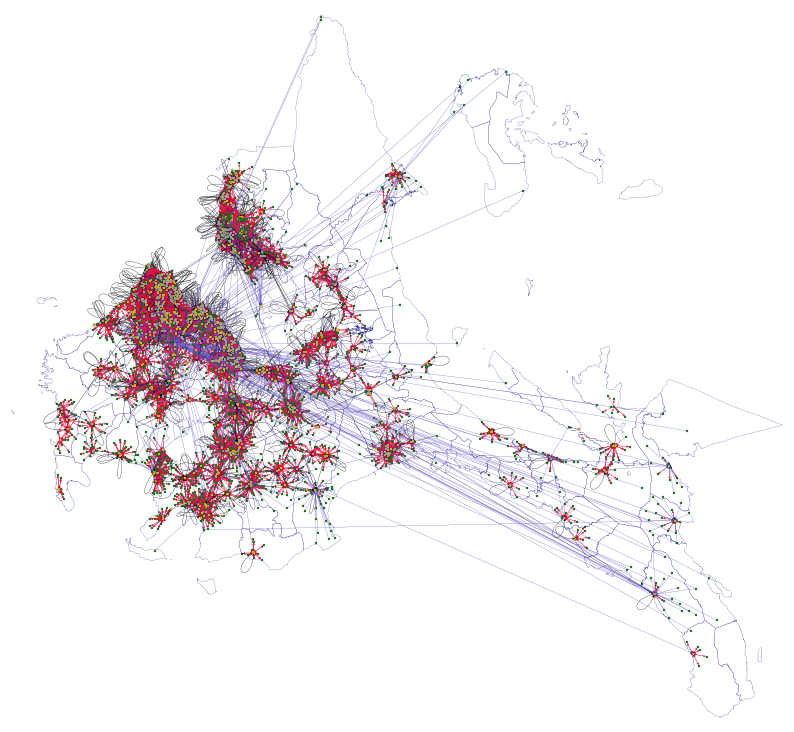

CPU times: user 23.3 s, sys: 629 ms, total: 23.9 s
Wall time: 23.1 s


In [219]:
%%time
fig, ax = plt.subplots(figsize=(10,10))

mult_savefig = 1
# Plot network anchored on the schools' lon-lat
iG.plot(
    subgraph_esc,
    target=ax,
    **visual_style,
    vertex_size=2*mult_savefig,
    vertex_frame_width=.1,
    edge_width=.1,           # Make edges thicker
    edge_arrow_size=2*mult_savefig,      # Control arrow size
    edge_arrow_width=2*mult_savefig,     # Control arrow width
    # bbox=(1000,1000),
    # margin=0
)

shape_4a = (
    geo_results['target_area']
    .dissolve(by='adm3_psgc')
    .to_crs(3123)
)

shape_4a.plot(
    ax=ax, facecolor='none', edgecolor='navy',
    linewidth=.15, alpha=.8,
)

cm_3123_shp = shape_4a.unary_union # This is 4326

min_x, min_y, max_x, max_y = cm_3123_shp.bounds
multiplier = 0.001
ax.set_xlim(min_x*(1 - multiplier), max_x*(1 + multiplier))
ax.set_ylim(min_y*(1 - multiplier), max_y*(1 + multiplier))

# plt.savefig(
#     '../output/region4a_esc_network.svg',
#     dpi=300, transparent=True, bbox_inches='tight',
# )

plt.show()
plt.close()

### Subgraph computation

In [176]:
df_data = []
for edge in subgraph_esc.es:
    source, target = edge.tuple
    edge_length = edge['length']
    edge_esc = edge['esc_beneficiaries']

    src_sch_id = subgraph_esc.vs[source]['school_id']
    src_sector = get_attrs(subgraph_esc.vs[source]).get('sector')
    src_region = get_attrs(subgraph_esc.vs[source]).get('region')

    tr_sch_id = subgraph_esc.vs[target]['school_id']
    tr_sector = get_attrs(subgraph_esc.vs[target]).get('sector')
    tr_region = get_attrs(subgraph_esc.vs[target]).get('region')
    tr_jhs_tuition = get_attrs(subgraph_esc.vs[target]).get('esc_(total)')

    row_values = [
        src_sch_id, src_sector, src_region,
        tr_sch_id, tr_sector, tr_region, tr_jhs_tuition,
        edge_length, edge_esc
     ]
    df_data.append(row_values)

df_data = np.array(df_data)

df_columns = [
    'origin_school_id',
    'origin_sector',
    'origin_region',
    'destination_school_id',
    'destination_sector',
    'destination_region',
    'destination_jhs_tuition',
    'schools_distance',
    'esc_beneficiaries'
]
df_esc = pd.DataFrame(
    data=df_data,
    columns=df_columns
)

# Destination should only be "Private"
mask = df_esc['destination_sector'] == 'Private'
df_esc = df_esc.loc[mask].copy()

In [177]:
print(df_esc.shape)
display(df_esc.sample(10))

(65322, 9)


,origin_school_id,origin_sector,origin_region,destination_school_id,destination_sector,destination_region,destination_jhs_tuition,schools_distance,esc_beneficiaries
58152,401931,Private,Region IV-A,424113,Private,Region IV-A,9000.0,3425.532,None
3789,109837,Public,Region IV-A,403347,Private,Region IV-A,23920.0,1381.576,None
33956,402150,Private,Region IV-A,424021,Private,Region IV-A,NaN,6629.703,None
48250,424583,Private,Region IV-A,402431,Private,Region IV-A,NaN,2290.27,None
5141,107902,Public,Region IV-A,424024,Private,Region IV-A,41000.0,4439.024,None
1850,107254,Public,Region IV-A,401612,Private,Region IV-A,36582.04,12936.271,None
51525,403364,Private,Region IV-A,428553,Private,Region IV-A,NaN,4122.969,None
1408,109701,Public,Region IV-A,403233,Private,Region IV-A,21132.9,3695.723,None
37135,402185,Private,Region IV-A,424145,Private,Region IV-A,NaN,6685.155,None
75689,485536,Private,NCR,403017,Private,Region IV-A,37800.0,494.925,None


In [178]:
df_esc.isna().sum()

origin_school_id               0
origin_sector                  0
origin_region                  0
destination_school_id          0
destination_sector             0
destination_region             0
destination_jhs_tuition    19293
schools_distance             660
esc_beneficiaries          63715
dtype: int64

In [185]:
df_esc['destination_school_id'].nunique()

1677

In [188]:
# df_esc[df_esc['destination_jhs_tuition'].isna()]
display(df_esc[df_esc['destination_jhs_tuition'].isna()]['destination_school_id'].unique())
# display(df_esc[df_esc['destination_jhs_tuition'].isna()]['destination_school_id'].nunique())

array([402783, 402837, 425088, ..., 425526, 425553, 425774], dtype=object)

In [56]:
mask = df_esc['esc_beneficiaries'] > 0
df_n = df_esc.loc[mask].copy()
print(df_n.shape)

(1736, 9)


In [79]:
df_n['esc_beneficiaries'].sum()

5445

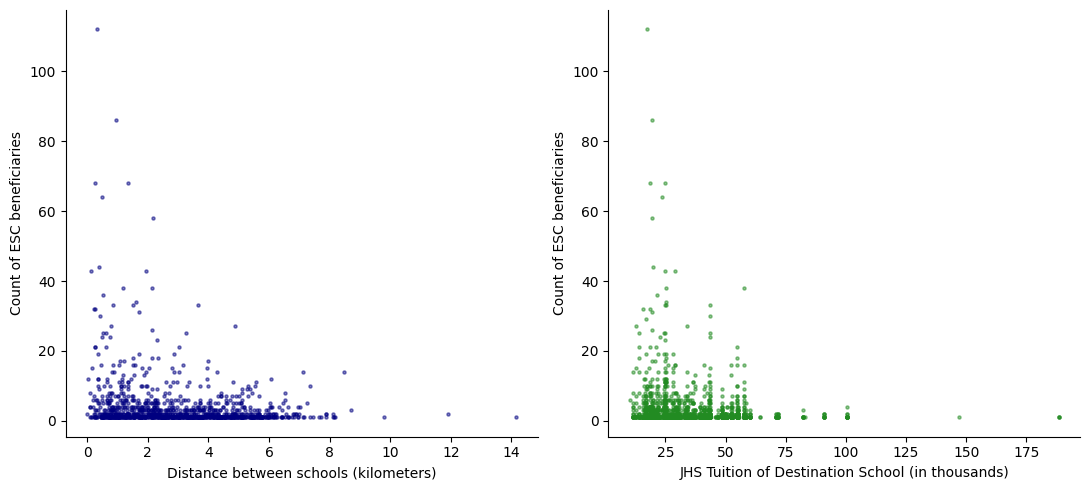

In [77]:
fig, ax = plt.subplots(1,2,figsize=(11,5))
ax = ax.ravel()

df_n.plot(
    ax=ax[0], kind='scatter',
    x='schools_distance', y='esc_beneficiaries',
    s=5, alpha=.5, c='navy'
)

# x-axis
ax[0].set_xlabel('Distance between schools (kilometers)')
def val_formatter(x, pos=None):
    return f"{(x / 1e3):,.0f}"
ax[0].xaxis.set_major_formatter(FuncFormatter(val_formatter))

# y-axis
ax[0].set_ylabel('Count of ESC beneficiaries')

df_n.plot(
    ax=ax[1], kind='scatter',
    x='destination_jhs_tuition', y='esc_beneficiaries',
    s=5, alpha=.5, c='forestgreen'
)
ax[1].set_xlabel('JHS Tuition of Destination School (in thousands)')
def val_formatter(x, pos=None):
    return f"{(x / 1e3):,.0f}"
ax[1].xaxis.set_major_formatter(FuncFormatter(val_formatter))
ax[1].set_ylabel('Count of ESC beneficiaries')

for a in ax:
    a.spines[['top','right']].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()

In [123]:
%%time
path = '../datasets/public/SY 2024-2025 JHS ESC Tagged Learners in LIS (from their previous G6 Schools).xlsx'
excel_esc = pd.read_excel(path, sheet_name='Sheet1')
print(excel_esc.shape)

path = '../datasets/_SY 2024-2025 SCHOOL LEVEL DATA ON ENROLLMENT.xlsx'
excel_enr = pd.read_excel(path, sheet_name='DB', header=5)
print(excel_enr.shape)

(14804, 5)
(60127, 77)
CPU times: user 44.2 s, sys: 200 ms, total: 44.4 s
Wall time: 53.5 s


In [125]:
df_esc = excel_esc.copy()
df_esc['School ID (Origin Grade 6)'] = df_esc['School ID (Origin Grade 6)'].astype('string')
df_esc = df_esc.set_index('School ID (Origin Grade 6)')
display(df_esc.head(2))

,School Name (Origin Grade 6),School ID (Destination Grade 7),School Name (Destination Grade 7),Count of Learners
School ID (Origin Grade 6),,,,
100000,Balayong Elementary School,400312,Virgen Milagrosa Special Science High School,1
100002,Bacarra CES,400001,"St. Andrew Academy of Bacarra, Inc.",1


In [126]:
df_enr = excel_enr.copy()
df_enr['BEIS School ID'] = df_enr['BEIS School ID'].astype('string')
df_enr = df_enr.set_index('BEIS School ID')
display(df_enr.head(2))

,Region,Division,District,School Name,Street Address,Mother School ID,Province,Municipality,Legislative District,Barangay,...,G12 ACAD PBM Male,G12 ACAD PBM Female,G12 TVL Male,G12 TVL Female,G12 SPORTS Male,G12 SPORTS Female,G12 ARTS Male,G12 ARTS Female,G12 UNIQUE Male,G12 UNIQUE Female
BEIS School ID,,,,,,,,,,,,,,,,,,,,,
100001,Region I,Ilocos Norte,Bacarra I,Apaleng-Libtong ES,"Brgy. 21, Libtong, Bacarra, Ilocos Norte",NaN,ILOCOS NORTE,BACARRA,1st District,LIBTONG,...,0,0,0,0,0,0,0,0,0,0
100002,Region I,Ilocos Norte,Bacarra I,Bacarra CES,Santa Rita,NaN,ILOCOS NORTE,BACARRA,1st District,SANTA RITA (POB.),...,0,0,0,0,0,0,0,0,0,0


In [127]:
df_jn = df_esc.join(
    df_enr[['Region','Division']],
    how='left'
)
df_jn = df_jn.reset_index()
print(df_jn.shape)
display(df_jn.head(3))

(14804, 7)


,School ID (Origin Grade 6),School Name (Origin Grade 6),School ID (Destination Grade 7),School Name (Destination Grade 7),Count of Learners,Region,Division
0,100000,Balayong Elementary School,400312,Virgen Milagrosa Special Science High School,1,Region I,San Carlos City
1,100002,Bacarra CES,400001,"St. Andrew Academy of Bacarra, Inc.",1,Region I,Ilocos Norte
2,100011,Santo Cristo Elementary School,400001,"St. Andrew Academy of Bacarra, Inc.",2,Region I,Ilocos Norte


In [128]:
df_jn.isna().sum()

School ID (Origin Grade 6)            0
School Name (Origin Grade 6)          0
School ID (Destination Grade 7)       0
School Name (Destination Grade 7)     0
Count of Learners                     0
Region                               52
Division                             52
dtype: int64

In [133]:
df_jn[df_jn['Region'] == 'PSO']

,School ID (Origin Grade 6),School Name (Origin Grade 6),School ID (Destination Grade 7),School Name (Destination Grade 7),Count of Learners,Region,Division
14792,700001,Future Generation Philippine International School,402298,Rogationist College,1,PSO,Kingdom of Saudi Arabia
14793,700002,Philippine School (Bahrain),401094,"Vincentian Catholic Academy, Inc.",1,PSO,Kingdom of Bahrain
14794,700002,Philippine School (Bahrain),438012,Wadeford School,1,PSO,Kingdom of Bahrain
14795,700006,Elite International School,407220,De La Salle Araneta University,1,PSO,Kingdom of Saudi Arabia
14796,700013,Philippine International School-Qatar,406521,Good Shepherd Cathedral School,1,PSO,Qatar
14797,700019,United International Private School,402978,"Child Jesus of Prague School, Inc.",1,PSO,United Arab Emirates
14798,700019,United International Private School,424598,University of Perpetual Help System Laguna,1,PSO,United Arab Emirates
14799,700023,International Philippine School in Riyadh,405287,La Salle Academy,1,PSO,Kingdom of Saudi Arabia
14800,700032,Far Eastern Private School-Al Shahba,400610,"St. John's Academy, Inc",1,PSO,United Arab Emirates
14801,700032,Far Eastern Private School-Al Shahba,400929,"School of Mount St. Mary, Inc.",1,PSO,United Arab Emirates


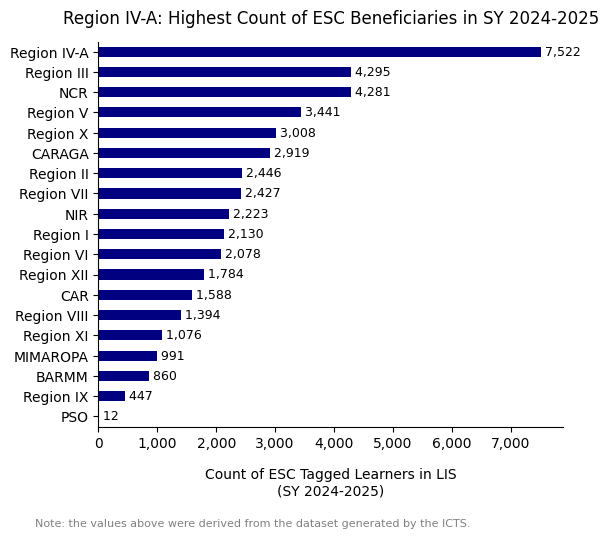

In [132]:
fig, ax = plt.subplots(figsize=(6,5))

# Get the Series after groupby and sum, before plotting
plot_data = df_jn.groupby(['Region'])['Count of Learners'].sum().sort_values(ascending=True)

plot_data.plot(
    ax=ax,
    kind='barh',
    color='navy'
)

ax.spines[['top','right']].set_visible(False)
ax.set_ylabel('')

ax.set_xlabel('Count of ESC Tagged Learners in LIS\n(SY 2024-2025)', labelpad=12.5)
def val_formatter(x, pos=None):
    return f"{(x):,.0f}"
ax.xaxis.set_major_formatter(FuncFormatter(val_formatter))

ax.set_title("Region IV-A: Highest Count of ESC Beneficiaries in SY 2024-2025", y=1.025)

# --- Add this section to annotate the bars ---
for i, v in enumerate(plot_data):
    ax.text(v, i, f' {v:,.0f}', va='center', ha='left', fontsize=9, color='black')
# --- End of annotation section ---

# --- Add this section for the footer ---
footer_text = "Note: the values above were derived from the dataset generated by the ICTS."
fig.text(0.02, -0.095, footer_text, ha='left', va='bottom', fontsize=8, color='#808080')
# --- End of footer section ---

plt.show()
plt.close()

### Validate network

#### Panukulan, Quezon

In [154]:
mask = (
    (public['region'].str.contains(r"iv-a", flags=re.IGNORECASE))
    & (public['province'].str.contains(r"quezon", flags=re.IGNORECASE))
    & (public['municipality'].str.contains(r"panukul", flags=re.IGNORECASE))
)
df_ins = public.loc[mask].copy()
print(df_ins.shape)

(18, 24)


In [155]:
df_ins.head(2)

,region,division,school_name,province,municipality,longitude,latitude,shifting_schedule,modified coc,seats_es,...,enrollment_shs,shs_ABM,shs_ARTS & DESIGN,shs_GAS,shs_HUMSS,shs_PBM,shs_SPORTS,shs_STEM,shs_TVL,sector
school_id,,,,,,,,,,,,,,,,,,,,,
108559,Region IV-A,Quezon,Bongliw ES,QUEZON,PANUKULAN,121.943711,15.052066,No Shift,Purely ES,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Public
108569,Region IV-A,Quezon,Rizal ES,QUEZON,PANUKULAN,121.969435,15.048903,No Shift,Purely ES,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Public


In [153]:
df_ins['municipality'].unique()

array(['ALABAT', 'ATIMONAN', 'BUENAVISTA', 'BURDEOS', 'CALAUAG',
       'CANDELARIA', 'CATANAUAN', 'DOLORES', 'GENERAL LUNA',
       'GENERAL NAKAR', 'GUINAYANGAN', 'GUMACA', 'INFANTA', 'LOPEZ',
       'LUCBAN', 'MACALELON', 'MAUBAN', 'MULANAY', 'AGDANGAN',
       'PADRE BURGOS', 'PAGBILAO', 'PATNANUNGAN', 'JOMALIG', 'PEREZ',
       'PITOGO', 'PLARIDEL', 'POLILLO', 'QUEZON', 'LUCENA CITY (Capital)',
       'CITY OF TAYABAS', 'REAL', 'SAMPALOC', 'SAN ANDRES', 'SAN ANTONIO',
       'SAN FRANCISCO (AURORA)', 'SAN NARCISO', 'SARIAYA', 'TAGKAWAYAN',
       'TIAONG', 'UNISAN', 'PANUKULAN'], dtype=object)

In [163]:
uniq_pub_ids = df_ins.index.tolist()
uniq_pub_ids = [str(el) for el in uniq_pub_ids]
print(uniq_pub_ids)

['108559', '108569', '109021', '109022', '109026', '109028', '109031', '109034', '109035', '109037', '109038', '109039', '109041', '109042', '301344', '301396', '301397', '308029']


In [162]:
df_esc[df_esc.index.isin(uniq_pub_ids)]

,School Name (Origin Grade 6),School ID (Destination Grade 7),School Name (Destination Grade 7),Count of Learners
School ID (Origin Grade 6),,,,
108569,Rizal ES,402305,"Sisters of Mary School-Adlas, Inc.",1
108569,Rizal ES,424131,"Sisters of Mary of Banneux, Inc.",1
109022,Bato ES,402305,"Sisters of Mary School-Adlas, Inc.",1
109022,Bato ES,402757,Mt. Carmel School of Infanta,1
109035,Lipata ES,402305,"Sisters of Mary School-Adlas, Inc.",1
109039,Pagitan ES,406306,Arellano University(Juan Sumulong High School),1
109039,Pagitan ES,424131,"Sisters of Mary of Banneux, Inc.",1
109041,Pandan ES,402757,Mt. Carmel School of Infanta,1
109042,Panukulan CS,402305,"Sisters of Mary School-Adlas, Inc.",3


#### Mulanay, Quezon

In [167]:
mask = (
    (public['region'].str.contains(r"iv-a", flags=re.IGNORECASE))
    & (public['province'].str.contains(r"quezon", flags=re.IGNORECASE))
    & (public['municipality'].str.contains(r"mulanay", flags=re.IGNORECASE))
)
df_ins = public.loc[mask].copy()
print(df_ins.shape)
print(df_ins['school_name'].unique().tolist())

print()
uniq_pub_ids = df_ins.index.tolist()
uniq_pub_ids = [str(el) for el in uniq_pub_ids]
print(uniq_pub_ids)

(33, 24)
['Acaciahan ES', 'Ajos ES', 'Anonang ES', 'Bagupaye ES', 'Bolo Elementary School', 'Buenavista ES', 'Burgos ES', 'Calangcang ES', 'Canuyep ES', 'Ibabang Yuni ES', 'Ilayang Yuni ES', 'Ilayang Cambuga ES', 'Latangan ES', 'Magsaysay ES', 'Malibago ES', 'Matataja ES', 'Mulanay CES', 'PakIIng ES', 'Parang ES', 'Patabog ES', 'Pinagpalapalahan ES', 'San Isidro ES', 'San Pedro ES', 'Santa Rosa ES', 'Sumagonsong ES', 'Ajos National High School', 'Magsaysay NHS (Formerly Ajos NHS - Magsaysay Extension)', 'Bagupaye  Integrated High School', 'Bondoc Peninsula Agri. HS', 'Ilayang Yuni Junior and Senior Integrated NHS', 'PAKIING NATIONAL HIGH SCHOOL', 'Doña Francisca Alvarez Rejano Integrated School (Formerly Patabog NHS)', 'BURGOS NHS (FORMERLY BARANGAY BURGOS NATIONAL HIGH SCHOOL']

['108918', '108919', '108920', '108921', '108922', '108923', '108924', '108925', '108927', '108928', '108929', '108930', '108931', '108932', '108933', '108934', '108935', '108936', '108937', '108938', '108939'

In [166]:
df_esc[df_esc.index.isin(uniq_pub_ids)]

,School Name (Origin Grade 6),School ID (Destination Grade 7),School Name (Destination Grade 7),Count of Learners
School ID (Origin Grade 6),,,,
108918,Acaciahan ES,402305,"Sisters of Mary School-Adlas, Inc.",1
108918,Acaciahan ES,424131,"Sisters of Mary of Banneux, Inc.",1
108919,Ajos ES,402784,MULANAY INSTITUTE,2
108921,Bagupaye ES,402784,MULANAY INSTITUTE,4
108921,Bagupaye ES,424131,"Sisters of Mary of Banneux, Inc.",1
108922,Bolo Elementary School,402784,MULANAY INSTITUTE,2
108923,Buenavista ES,402784,MULANAY INSTITUTE,3
108924,Burgos ES,424131,"Sisters of Mary of Banneux, Inc.",1
108925,Calangcang ES,402784,MULANAY INSTITUTE,1
